# Working with COVID-19 Business Survey Data

This notebook aims to examine the impact the onset of the pandemic in March had on UK businesses and provides an interesting insight into what may happen should the UK experience a second wave of the virus or indeed any future pandemic.
To create this dataset we've combined UK Business Counts data and Business Impact of Coronavirus Survey responses (found here: https://www.ons.gov.uk/economy/economicoutputandproductivity/output/datasets/businessimpactofcovid19surveybicsresults). From the period 23 March to 5 April, the key question for businesses we will examine is the following:

How confident are you that your enterprise has the financial resources to continue operating throughout the coronavirus (COVID-19) outbreak?

The aim of this short notebook is to give you some examples of the insights and visualisations we generated from our curated dataset and to give you an opportunity to expand on it or take the data in a different direction. We have made both the start and end dataset of this notebook available for you to do so.

## Imports and Loading in of Data

In [22]:
import requests
import json
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

Below we load in the data using the provided business confidence API.

In [24]:
response = json.loads(requests.get("https://iqapi.azurewebsites.net/api/BusinessConfidence").text)

In [25]:
for value in response.values():
    data = value

In [26]:
df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')

In [27]:
df.columns = ['Industry', 'Local Authority Code', 'Local Authority', 'Size Band', 'Business Size', 'Start Date', 'End Date', 'Businesses Confident', 'Businesses Not Sure', 'Businesses Not Confident', 'Businesses Not Paused Trading', 'Business Count']

In [28]:
df.head()

,Industry,Local Authority Code,Local Authority,Size Band,Business Size,Start Date,End Date,Businesses Confident,Businesses Not Sure,Businesses Not Confident,Businesses Not Paused Trading,Business Count
0,B : Mining and quarrying,S12000033,Aberdeen City,0 to 4,Small,23-Mar-20,05-Apr-20,17,5,1,7,30
1,B : Mining and quarrying,S12000033,Aberdeen City,10 to 19,Small,23-Mar-20,05-Apr-20,3,1,0,1,5
2,B : Mining and quarrying,S12000033,Aberdeen City,100 to 249,Medium,23-Mar-20,05-Apr-20,3,1,0,1,5
3,B : Mining and quarrying,S12000033,Aberdeen City,1000+,Large,23-Mar-20,05-Apr-20,3,1,0,1,5
4,B : Mining and quarrying,S12000033,Aberdeen City,20 to 49,Medium,23-Mar-20,05-Apr-20,6,2,0,2,10


We can see from opening up the data above that three columns contain the counts of survey responses to the question proposed above. The other contains information on businesses affected to the extent that they are temporarily unable to trade. We can also see that these responses are counted for every UK Local Authority, at varying industry categorisations as well as employee size bands. The first row for example shows us survey response counts for Mining & Quarrying businesses in Aberdeen City that employ between 0 and 4 people.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51570 entries, 0 to 51569
Data columns (total 12 columns):
Industry                         51570 non-null object
Local Authority Code             51570 non-null object
Local Authority                  51570 non-null object
Size Band                        51570 non-null object
Business Size                    51570 non-null object
Start Date                       51570 non-null object
End Date                         51570 non-null object
Businesses Confident             51570 non-null object
Businesses Not Sure              51570 non-null object
Businesses Not Confident         51570 non-null object
Businesses Not Paused Trading    51570 non-null object
Business Count                   51570 non-null object
dtypes: object(12)
memory usage: 4.7+ MB


Upon checking the data types above, we need to convert the count columns to integers.

In [30]:
df[['Businesses Confident', 'Businesses Not Sure', 'Businesses Not Confident', 'Businesses Not Paused Trading',
    'Business Count']] = df[['Businesses Confident','Businesses Not Sure', 'Businesses Not Confident',
                             'Businesses Not Paused Trading', 'Business Count']].astype(int)

## Business Risk Metric

The lines of code below will help us to generate a very simple metric of Business Risk that we will later use to compare the Local Authorities to each other in terms of their exposure to the pandemic.

We can create a 'Negative Outlook' column which combines counts for the negative responses. These are where the business was unable to trade or were not confident about their ability to cope with COVID-19.

In [31]:
df['Negative Outlook'] = df['Businesses Not Confident'] + df['Businesses Not Paused Trading']

In [32]:
df.head()

,Industry,Local Authority Code,Local Authority,Size Band,Business Size,Start Date,End Date,Businesses Confident,Businesses Not Sure,Businesses Not Confident,Businesses Not Paused Trading,Business Count,Negative Outlook
0,B : Mining and quarrying,S12000033,Aberdeen City,0 to 4,Small,23-Mar-20,05-Apr-20,17,5,1,7,30,8
1,B : Mining and quarrying,S12000033,Aberdeen City,10 to 19,Small,23-Mar-20,05-Apr-20,3,1,0,1,5,1
2,B : Mining and quarrying,S12000033,Aberdeen City,100 to 249,Medium,23-Mar-20,05-Apr-20,3,1,0,1,5,1
3,B : Mining and quarrying,S12000033,Aberdeen City,1000+,Large,23-Mar-20,05-Apr-20,3,1,0,1,5,1
4,B : Mining and quarrying,S12000033,Aberdeen City,20 to 49,Medium,23-Mar-20,05-Apr-20,6,2,0,2,10,2


## Grouping of Data - Regional Impacts

To begin our analysis we'll attempt to understand these survey responses at a regional level. Here, we're interested in how different parts of the UK have been impacted in terms of the confidence of their businesses.

In [33]:
byLA = df.groupby(['Local Authority', 'Local Authority Code']).sum()

In [34]:
byLA.head()

,,Businesses Confident,Businesses Not Sure,Businesses Not Confident,Businesses Not Paused Trading,Business Count,Negative Outlook
Local Authority,Local Authority Code,,,,,,
Aberdeen City,S12000033,5219,1515,392,1335,8461,1727
Aberdeenshire,S12000034,6332,1899,506,1917,10654,2423
Adur,E07000223,1269,386,99,456,2210,555
Allerdale,E07000026,1665,520,143,842,3170,985
Amber Valley,E07000032,2265,693,185,915,4058,1100


The groupby operation performed above shows us summed survey response counts for each Local Authority in the UK. In row 1 column 3, we can see there were 5219 confident businesses in Aberdeen City.

In [35]:
byLA['Business Risk'] = np.array(byLA['Negative Outlook']/byLA['Business Count'])*100

Dividing by total businesses gives us a simple Business Risk metric, which shows the percentage of businesses either not confident or not trading in each Local Authority. Let's examine the 10 worst affected areas:

In [36]:
byLA['Business Risk'].sort_values(ascending = False).head(10)

Local Authority   Local Authority Code
Wellingborough    E07000156               44.931402
Isles of Scilly   E06000053               41.007194
Scarborough       E07000168               36.303630
Gwynedd           W06000002               34.403905
Argyll and Bute   S12000035               34.072790
East Lindsey      E07000137               32.808335
Pembrokeshire     W06000009               32.682019
Richmondshire     E07000166               32.137203
Isle of Anglesey  W06000001               31.889551
Conwy             W06000003               31.854380
Name: Business Risk, dtype: float64

And also the least troubled areas:

In [37]:
byLA['Business Risk'].sort_values(ascending = True).head(10)

Local Authority   Local Authority Code
City of London    E09000001               17.189618
Wokingham         E06000041               18.462441
Reading           E06000038               19.776995
Milton Keynes     E06000042               19.927509
Hart              E07000089               20.134519
Woking            E07000217               20.180847
Slough            E06000039               20.255209
St Albans         E07000240               20.276817
Warrington        E06000007               20.352811
Bracknell Forest  E06000036               20.373285
Name: Business Risk, dtype: float64

## Visualising the Data

We need a better way to understand this data at a UK wide level. In this section, we'll look to apply our dataset to a map of the UK to visualise Business Risk. We begin by loading in the available geojson file.

In [38]:
geo_data = gpd.read_file("HeathersFinal.geojson")

In [39]:
geo_data.head()

,bng_e,bng_n,lad17cd,lad17nm,lad17nmw,lat,long,objectid,st_areashape,st_lengthshape,geometry
0,451141,516887,E06000002,Middlesbrough,,54.5447,-1.21099,2,0.007482,0.535700,"MULTIPOLYGON (((-1.20258 54.57775, -1.20441 54..."
1,447157,531476,E06000001,Hartlepool,,54.6762,-1.27023,1,0.013038,0.879442,"POLYGON ((-1.24444 54.72237, -1.24562 54.72168..."
2,464359,519597,E06000003,Redcar and Cleveland,,54.5675,-1.00611,3,0.034006,1.266696,"MULTIPOLYGON (((-0.79590 54.55848, -0.79442 54..."
3,444937,518183,E06000004,Stockton-on-Tees,,54.5569,-1.30669,4,0.028472,1.424065,"POLYGON ((-1.25236 54.62542, -1.25410 54.62405..."
4,428029,515649,E06000005,Darlington,,54.5354,-1.56835,5,0.027429,1.316797,"POLYGON ((-1.43993 54.59520, -1.44158 54.59459..."


Performing some minor manipulations and merging our initial dataset with the geojson should mean we are ready to plot the data.

In [40]:
byLA = byLA.reset_index()

In [41]:
byLA = byLA.rename(columns={"Local Authority Code":"lad17cd"})

In [42]:
vis = pd.merge(geo_data, byLA, on='lad17cd')

In [43]:
vis.head()

,bng_e,bng_n,lad17cd,lad17nm,lad17nmw,lat,long,objectid,st_areashape,st_lengthshape,geometry,Local Authority,Businesses Confident,Businesses Not Sure,Businesses Not Confident,Businesses Not Paused Trading,Business Count,Negative Outlook,Business Risk
0,451141,516887,E06000002,Middlesbrough,,54.5447,-1.21099,2,0.007482,0.535700,"MULTIPOLYGON (((-1.20258 54.57775, -1.20441 54...",Middlesbrough,1809,536,140,678,3163,818,25.861524
1,447157,531476,E06000001,Hartlepool,,54.6762,-1.27023,1,0.013038,0.879442,"POLYGON ((-1.24444 54.72237, -1.24562 54.72168...",Hartlepool,1201,360,98,479,2138,577,26.987839
2,464359,519597,E06000003,Redcar and Cleveland,,54.5675,-1.00611,3,0.034006,1.266696,"MULTIPOLYGON (((-0.79590 54.55848, -0.79442 54...",Redcar and Cleveland,1647,493,130,647,2917,777,26.636956
3,444937,518183,E06000004,Stockton-on-Tees,,54.5569,-1.30669,4,0.028472,1.424065,"POLYGON ((-1.25236 54.62542, -1.25410 54.62405...",Stockton-on-Tees,3030,893,234,996,5153,1230,23.869591
4,428029,515649,E06000005,Darlington,,54.5354,-1.56835,5,0.027429,1.316797,"POLYGON ((-1.43993 54.59520, -1.44158 54.59459...",Darlington,1830,567,151,668,3216,819,25.466418


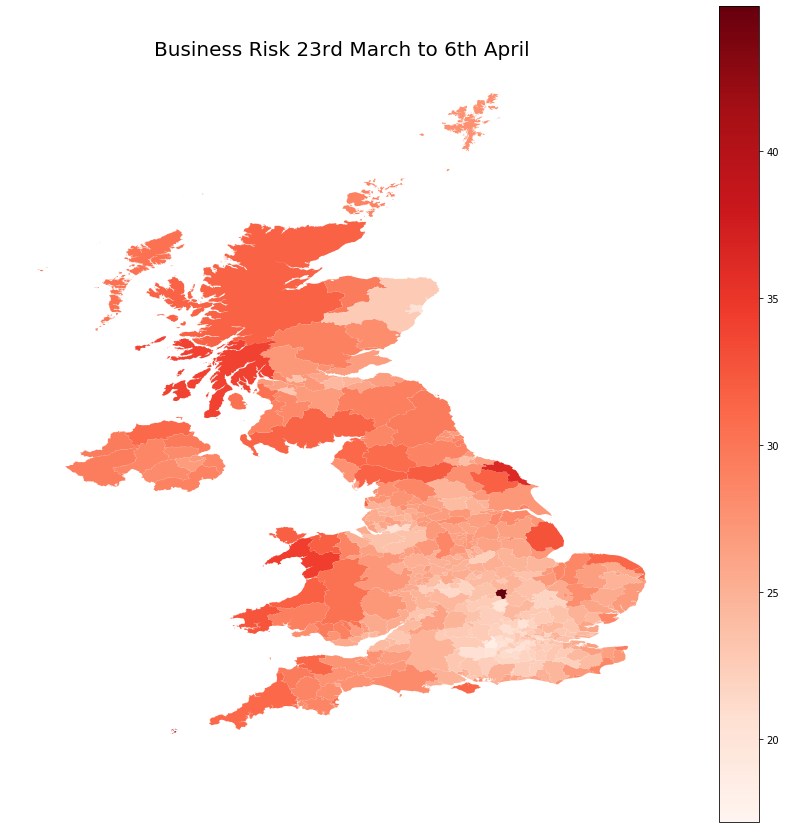

In [44]:
fig, ax = plt.subplots(figsize=(15,15))
vis.plot(ax=ax, column="Business Risk", legend=True, cmap='Reds', linewidth = 0.1)
plt.axis('off')
plt.grid(b=None)
plt.title("Business Risk 23rd March to 6th April", fontsize=20)
fig.patch.set_facecolor('white')
plt.show()

From first glance at the map, it would appear that many coastal areas of the UK are worst affected, as well as typical rural areas and areas of natural beauty. This perhaps should not come as a surprise considering these areas are likely to have a large proportion of businesses in the accommodation, hospitality and service sectors.

## Industry Impacts

Considering the above, we can analyse the business impact at an Industry level.

In [45]:
byIndustry = df.groupby(['Industry']).sum()

In [46]:
byIndustry

,Businesses Confident,Businesses Not Sure,Businesses Not Confident,Businesses Not Paused Trading,Business Count,Negative Outlook
Industry,,,,,,
B : Mining and quarrying,445,145,8,155,753,163
C : Manufacturing,80687,22316,5535,28004,136542,33539
"E : Water supply; sewerage, waste management and remediation activities",4824,1356,169,518,6867,687
F : Construction,167954,64165,19316,89519,340954,108835
G : Wholesale and retail trade; repair of motor vehicles and motorcycles,211532,64076,16812,94323,386743,111135
H : Transportation and storage,66713,26238,8022,9202,110175,17224
I : Accommodation and food service activities,16916,7298,4467,126019,154700,130486
J : Information and communication,166724,41693,6310,9975,224702,16285
L : Real estate activities,55398,16800,4532,22649,99379,27181


In [47]:
byIndustry = byIndustry.reset_index()

We'll again calculate our metric and sort the values by Business Risk for a neater looking plot.

In [48]:
byIndustry['Business Risk'] = np.array(byIndustry['Negative Outlook']/byIndustry['Business Count'])*100

In [49]:
byIndustry = byIndustry.sort_values(by = 'Business Risk', ascending = True)

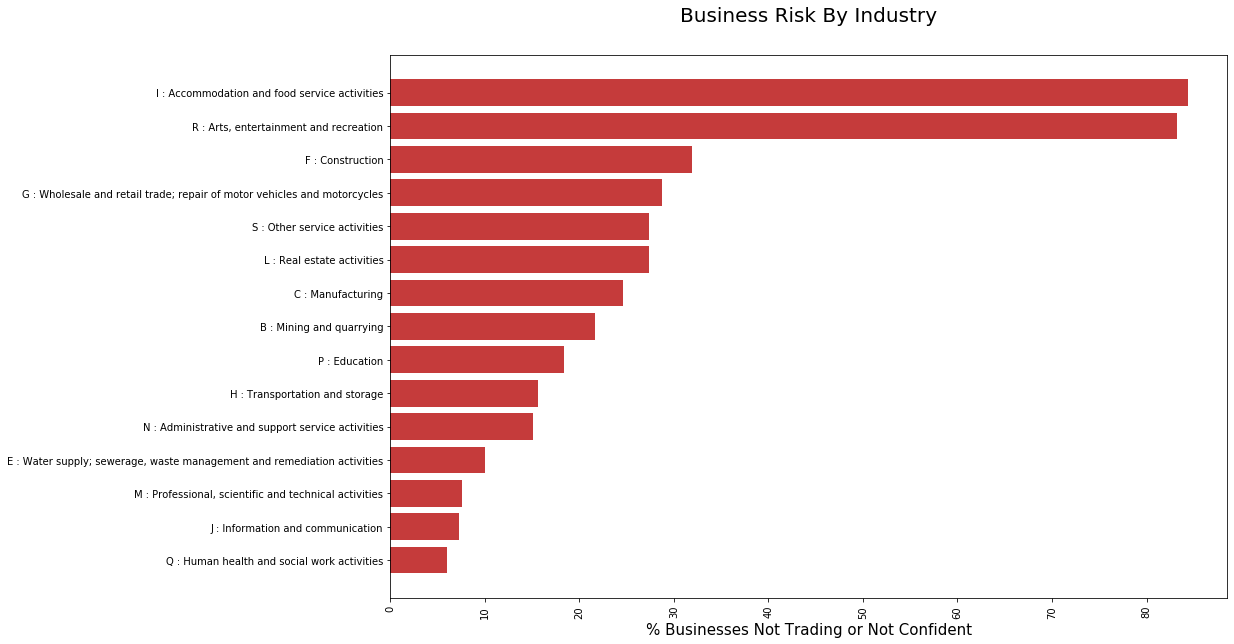

In [50]:

plt.figure(figsize = (15,10))
plt.title( 'Business Risk By Industry',
         fontsize = 20, y = 1.05)
plt.barh(byIndustry['Industry'],byIndustry['Business Risk'],color=(0.75, 0.15, 0.15, 0.1), alpha = 0.9)
plt.xticks(rotation = 90, fontsize = 10)
plt.rcParams['figure.facecolor'] = 'white'
plt.yticks(fontsize = 10)
plt.xlabel('% Businesses Not Trading or Not Confident', fontsize = 15)
plt.show()

This result should really be no surprise, especially when we look at the previous map data. Arts, Entertainment & Recreation as well as Accommodation & Food Service sectors are greatly affected by the pandemic. It would appear that the at risk areas of the UK would contain a lot of these businesses.

We can go into some further detail here and try to understand the size of the businesses being affected.

In [51]:
byIndSize = df.groupby(['Industry', 'Business Size']).sum()

In [52]:
byIndSize.reset_index(inplace = True)

In [53]:
byIndSize.head()

,Industry,Business Size,Businesses Confident,Businesses Not Sure,Businesses Not Confident,Businesses Not Paused Trading,Business Count,Negative Outlook
0,B : Mining and quarrying,Large,12,4,0,4,20,4
1,B : Mining and quarrying,Medium,33,11,0,11,55,11
2,B : Mining and quarrying,Small,400,130,8,140,678,148
3,C : Manufacturing,Large,534,176,2,178,890,180
4,C : Manufacturing,Medium,9170,2571,512,3080,15333,3592


In [54]:
byIndSize['Business Risk'] = np.array(byIndSize['Negative Outlook']/byIndSize['Business Count'])*100

For the purpose of visualising this data better, we will look to concatenate the Industry name and Business Size name into one column. We'll do this by creating a neat separator and then joining them together.

In [55]:
separator = ' ' + '-' + ' '

In [56]:
byIndSize['Size+Ind'] = byIndSize[['Industry', 'Business Size']].agg(separator.join, axis=1)

Checking with the head command it looks like we've got what we want. We'll now sort the values as before and then plot.

In [57]:
byIndSize.head()

,Industry,Business Size,Businesses Confident,Businesses Not Sure,Businesses Not Confident,Businesses Not Paused Trading,Business Count,Negative Outlook,Business Risk,Size+Ind
0,B : Mining and quarrying,Large,12,4,0,4,20,4,20.000000,B : Mining and quarrying - Large
1,B : Mining and quarrying,Medium,33,11,0,11,55,11,20.000000,B : Mining and quarrying - Medium
2,B : Mining and quarrying,Small,400,130,8,140,678,148,21.828909,B : Mining and quarrying - Small
3,C : Manufacturing,Large,534,176,2,178,890,180,20.224719,C : Manufacturing - Large
4,C : Manufacturing,Medium,9170,2571,512,3080,15333,3592,23.426596,C : Manufacturing - Medium


In [58]:
byIndSize = byIndSize.sort_values(by = 'Business Risk', ascending = True)

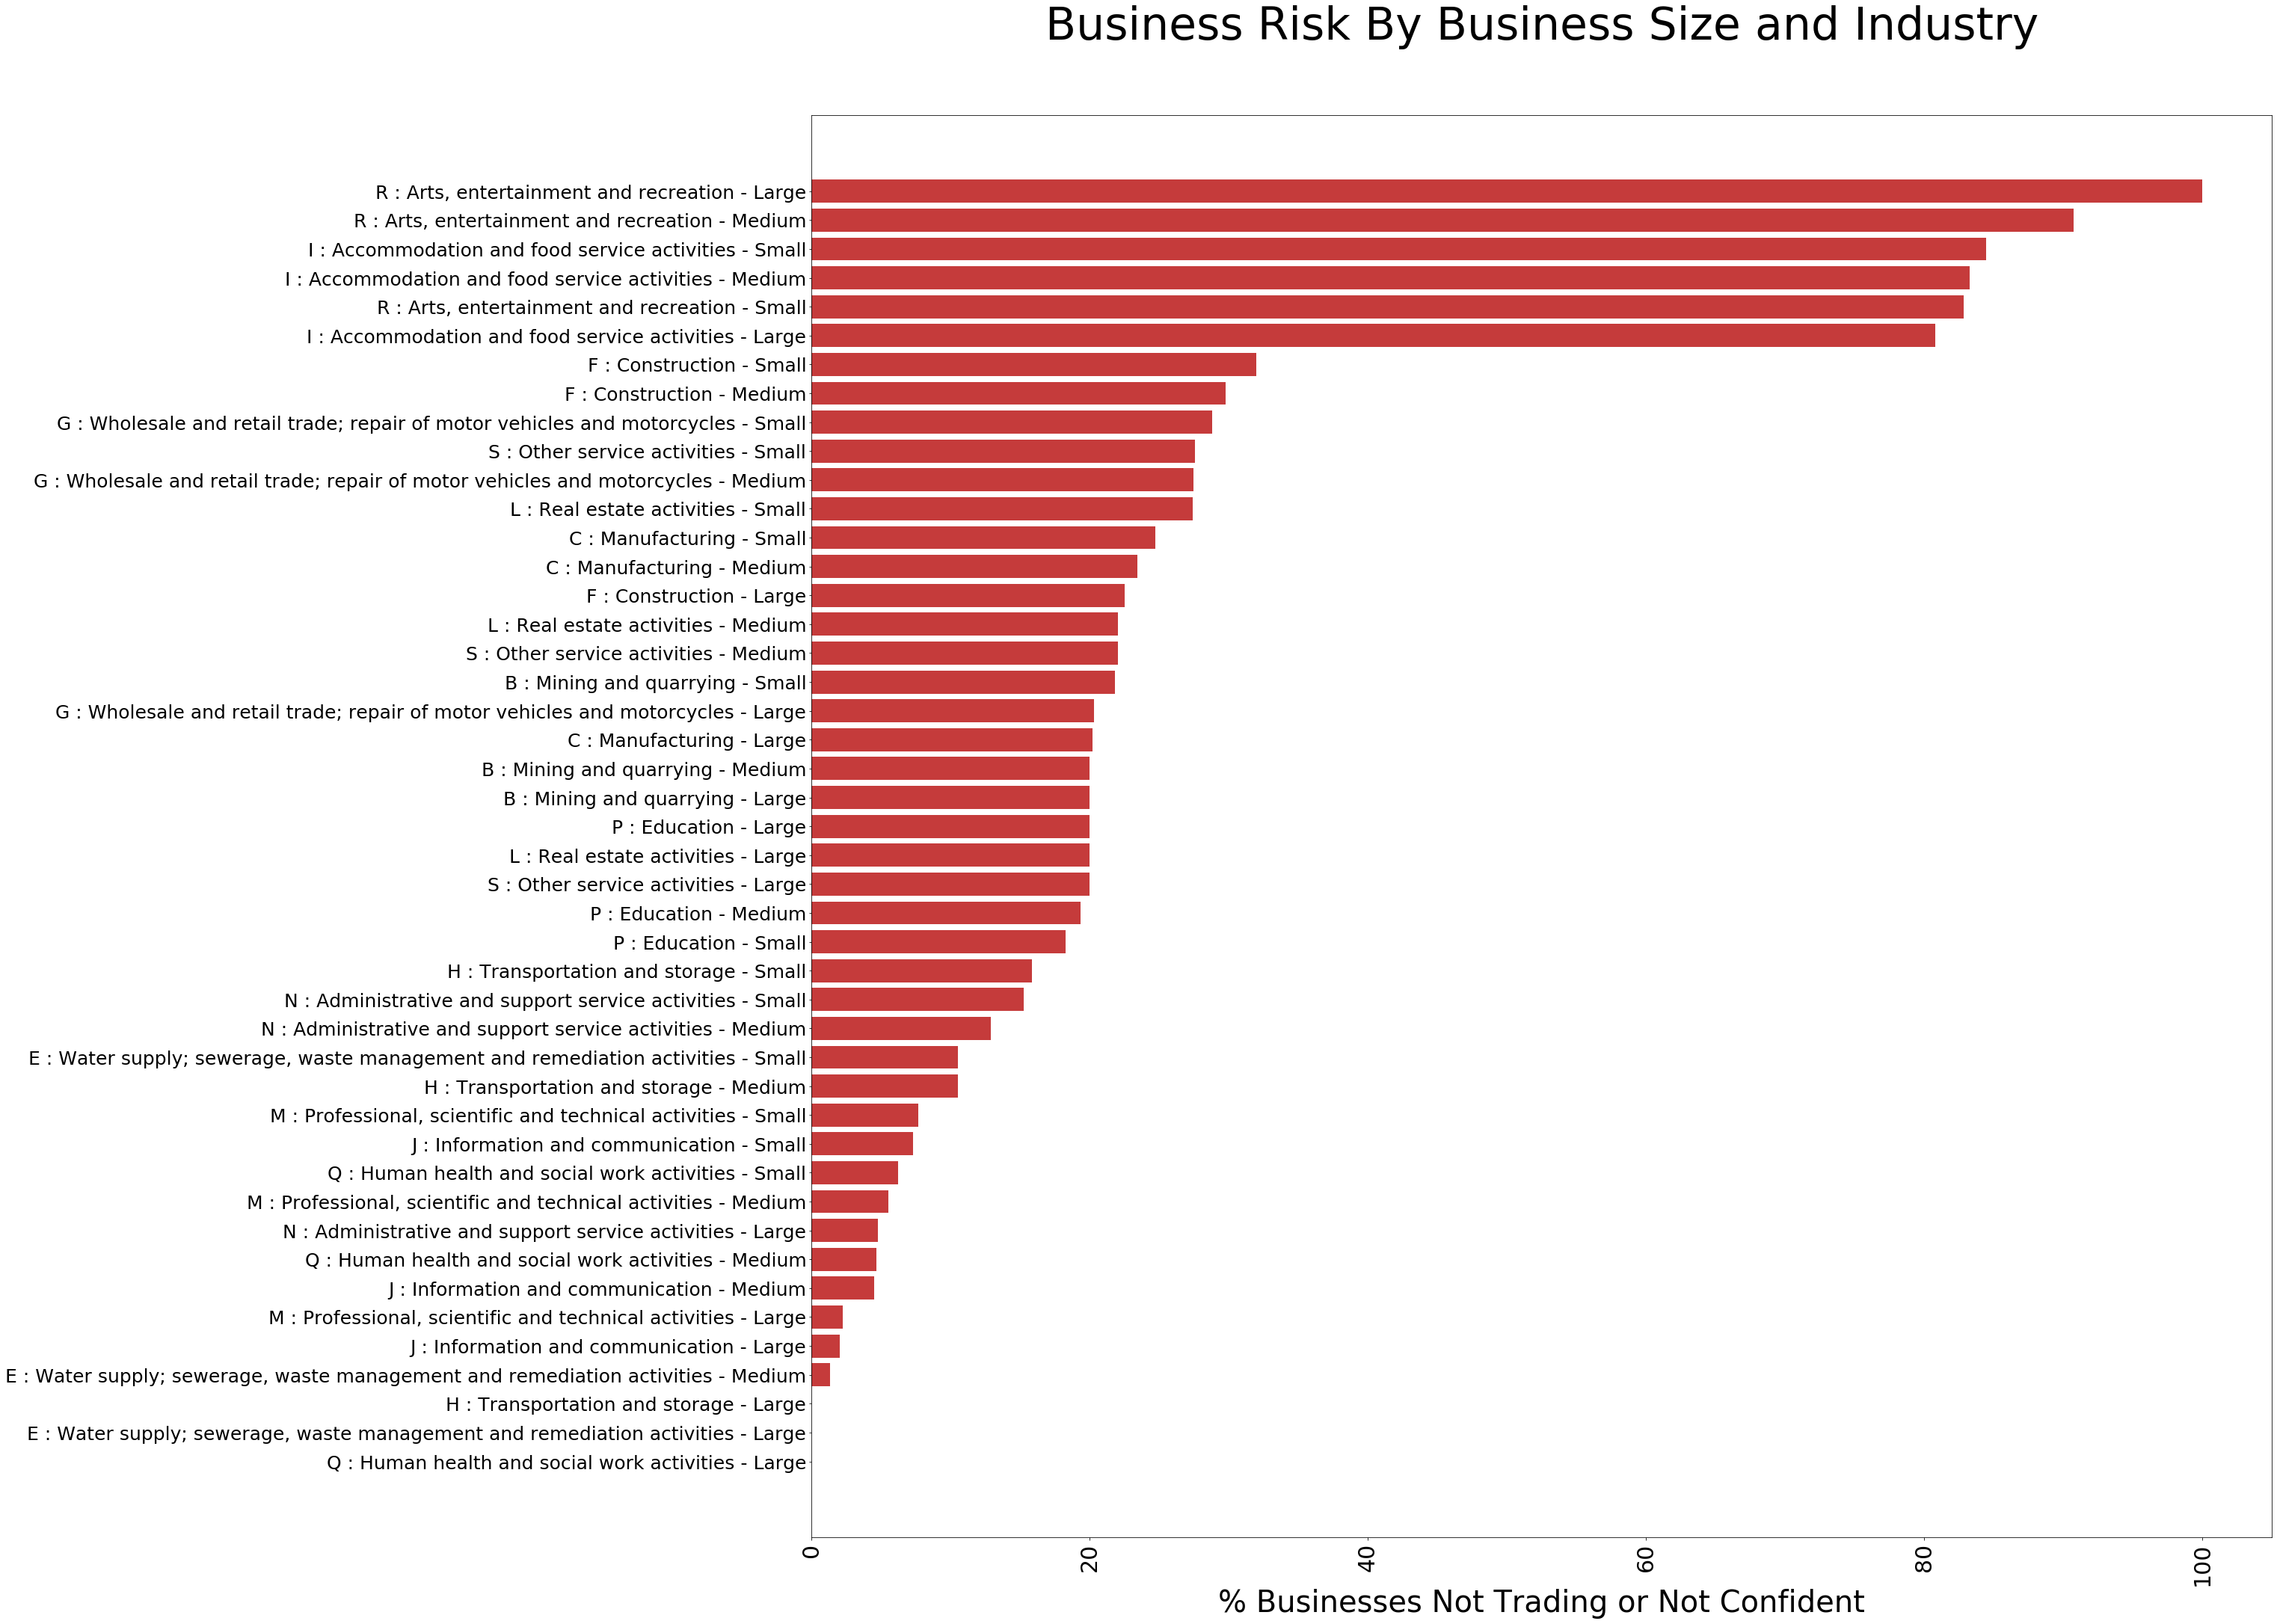

In [59]:
plt.figure(figsize = (35,35))
plt.title( 'Business Risk By Business Size and Industry',
         fontsize = 60, y = 1.05)
plt.barh(byIndSize['Size+Ind'],byIndSize['Business Risk'], color=(0.75, 0.15, 0.15, 0.1), alpha = 0.9)
plt.xticks(rotation = 90, fontsize = 30)
plt.xlabel('% Businesses Not Trading or Not Confident', fontsize = 40)
plt.yticks(fontsize = 25)
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

For the most affected industries, we can see that although there does not appear to be many great discrepancies between business sizes, larger businesses in the Entertainment Industry seem to be worse affected than smaller ones. The opposite appears to apply for Accommodation & Food services, where smaller businesses seem to be under slightly more pressure.